In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import norm
from tqdm.auto import tqdm
import pandahouse as ph
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(
    font_scale=2,
    style='whitegrid',
    rc={'figure.figsize': (20, 7)}
)

# Задание 1. A/B–тестирование

In [3]:
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-kim-36/Проект_2_groups.csv', sep=';')
groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-kim-36/Проект_2_group_add.csv', sep=',')
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-kim-36/Проект_2_active_studs.csv', sep=';')
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-kim-36/Проект_2_checks.csv', sep=';')

Перед началом работы проверим данные на наличие пустых значений и дубликатов.

In [4]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [5]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [6]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [7]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [8]:
groups.duplicated().sum()

0

In [9]:
groups_add.duplicated().sum()

0

In [10]:
active_studs.duplicated().sum()

0

In [11]:
checks.duplicated().sum()

0

Пропущенных значений и дубликатов нет.

In [12]:
active_studs = active_studs.rename(columns={'student_id': 'id'})
checks = checks.rename(columns={'student_id': 'id'})
# Переименуем столбцы для удобства дальнейшей работы

In [13]:
groups_all = pd.concat([groups, groups_add])
# Объединяем все данные по группам

In [14]:
# Создаем датафрейм для дальнейшей работы
active_users = active_studs.merge(checks, how='left', on='id')
active_users = active_users.merge(groups_all, how='left', on='id')

In [15]:
active_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8341 non-null   int64  
 1   rev     392 non-null    float64
 2   grp     8341 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 260.7+ KB


In [16]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      541 non-null    int64  
 1   rev     541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


В данных есть аномалия. Есть пользователи, совершившие оплату, но не являющиеся активными пользователями. Возможно, оплата просто списывается автоматически, не требуя активности на платформе.

In [17]:
active_users = active_users.fillna(0)
# Заполним пустые ячейки нулями

# На какие метрики Вы смотрите в ходе анализа и почему?

В ходе анализа A/B-тестирования, где целевой группе была предложена новая механика оплаты услуг на сайте, а контрольной группе оставалась базовая механика, можно рассмотреть следующие метрики:

    Конверсия - позволяет оценить, насколько успешно новая механика влияет на поведение пользователей.
    
    ARPU - позволяет оценить, какой средний доход приносит каждый пользователь в среднем, включая как платящих, так и неплатящих пользователей.
    
    ARPPU - различия в среднем чеке между группами могут указывать на эффективность новой механики оплаты.
    
    Значимость различий - при анализе результатов A/B-тестирования важно также оценить статистическую значимость различий между группами. Это позволяет определить, насколько вероятно, что различия между группами не являются случайными, а являются результатом влияния новой механики оплаты.
    
Анализ этих метрик позволит оценить эффективность новой механики оплаты и принять решение о ее запуске для всех пользователей.

# Имеются ли различия в показателях и с чем они могут быть связаны?

In [18]:
# Подсчет метрик
metrics = active_users.groupby('grp', as_index=False) \
                      .agg(all_users=('id', 'count'), 
                           paying_users=('rev', lambda x: x[x > 0].count()), 
                           revenue=('rev', 'sum'))

metrics['CR'] = round(metrics['paying_users'] / metrics['all_users'] * 100, 2)
metrics['ARPU'] = round(metrics['revenue'] / metrics['all_users'], 2)
metrics['ARPPU'] = round(metrics['revenue'] / metrics['paying_users'], 2)

In [19]:
metrics

,grp,all_users,paying_users,revenue,CR,ARPU,ARPPU
0,A,1538,78.0,72820.0000,5.07,47.35,933.59
1,B,6803,314.0,394974.0035,4.62,58.06,1257.88


Показатели метрик, кроме конверсии, выше у экспериментальной группы. Выборки групп значительно различаются, возможно это как-то влияет на различия в показателях. Чтобы сделать какой-то вывод, нужно проверить статистическую значимость различий.

# Являются ли эти различия статистически значимыми?

Проверим данные на нормальность распределения.

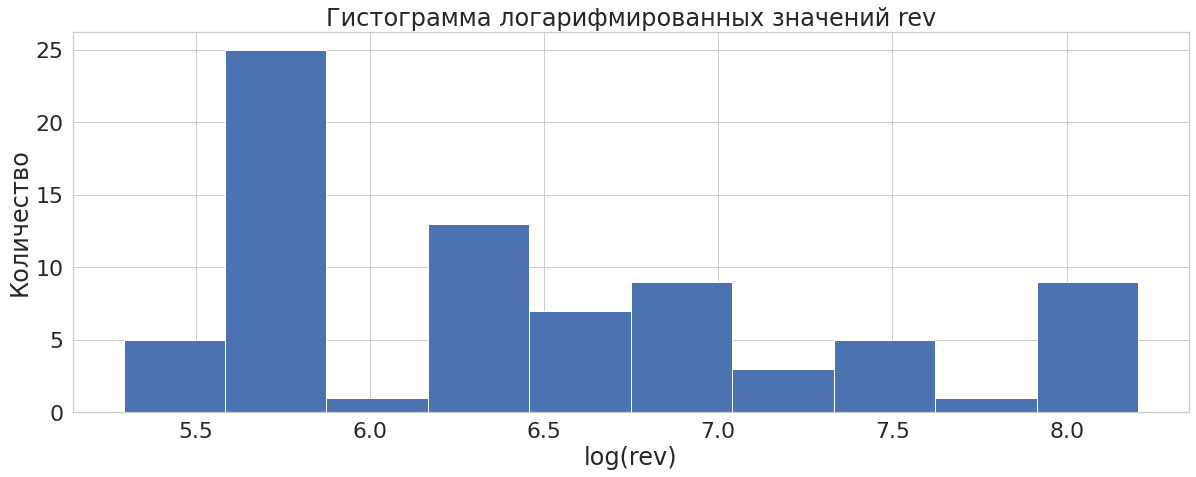

In [20]:
log_rev = np.log(active_users.query('grp == "A" & rev > 0').rev)

# Построение гистограммы на логарифмированных значениях
plt.hist(log_rev, bins=10) 
plt.xlabel('log(rev)')
plt.ylabel('Количество')
plt.title('Гистограмма логарифмированных значений rev')
plt.show()

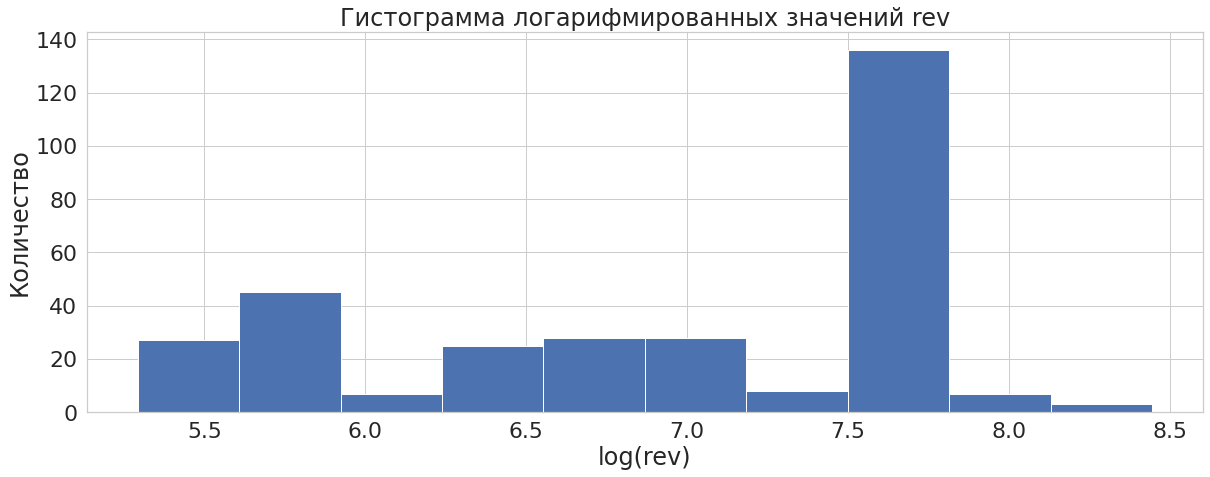

In [21]:
log_rev = np.log(active_users.query('grp == "B" & rev > 0').rev)

# Построение гистограммы на логарифмированных значениях
plt.hist(log_rev, bins=10) 
plt.xlabel('log(rev)')
plt.ylabel('Количество')
plt.title('Гистограмма логарифмированных значений rev')
plt.show()

Видим, что распределения в двух группах не являются нормальными. Далее посмотрим на наличие выбросов.

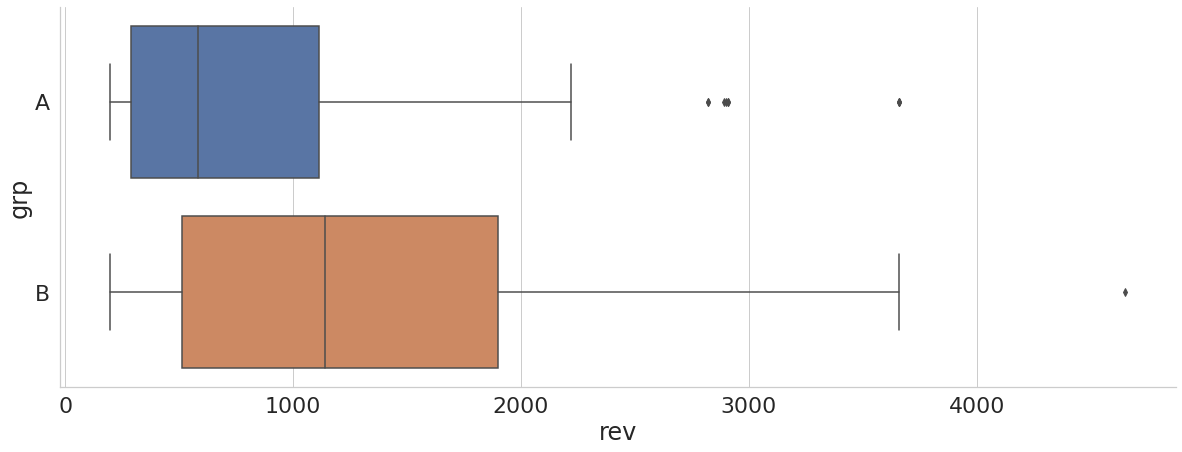

In [22]:
# Построим боксплоты для наглядности
sns.boxplot(data=active_users[active_users.rev > 0], x='rev', y='grp')
sns.despine()

Видим наличие выбросов. Для больших выборок требование нормальности для t-теста не особо важно, но выбросы всё ещё критичны, и именно они влияют на t-тест. Поэтому в этом случае я буду использовать бутстрап.

# Проверка для ARPU

Н0: Средний доход на одного пользователя (ARPU) не отличается между группами

Н1: Средний доход на одного пользователя (ARPU) отличается между группами

In [23]:
def get_bootstrap(data_column_1, data_column_2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95):
    """Выполняет бутстрэп-анализ для двух выборок и возвращает результаты.

    Функция принимает числовые значения двух выборок, выполняет бутстрэп-подвыборки,
    вычисляет интересующую нас статистику, определяет доверительные интервалы и p-значение,
    а также отображает гистограмму распределения бутстрэп-подвыборок.

    Args:
        data_column_1 (array-like): Числовые значения первой выборки.
        data_column_2 (array-like): Числовые значения второй выборки.
        boot_it (int, optional): Количество бутстрэп-подвыборок. По умолчанию 1000.
        statistic (function, optional): Интересующая нас статистика. По умолчанию np.mean.
        bootstrap_conf_level (float, optional): Уровень значимости для доверительных интервалов. По умолчанию 0.95.

    Returns:
        dict: Результаты бутстрэп-анализа в виде словаря с ключами "boot_data", "quants" и "p_value".

    """
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = np.random.choice(data_column_1, len(data_column_1), replace=True)
        samples_2 = np.random.choice(data_column_2, len(data_column_1), replace=True)
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data, "quants": quants, "p_value": p_value}

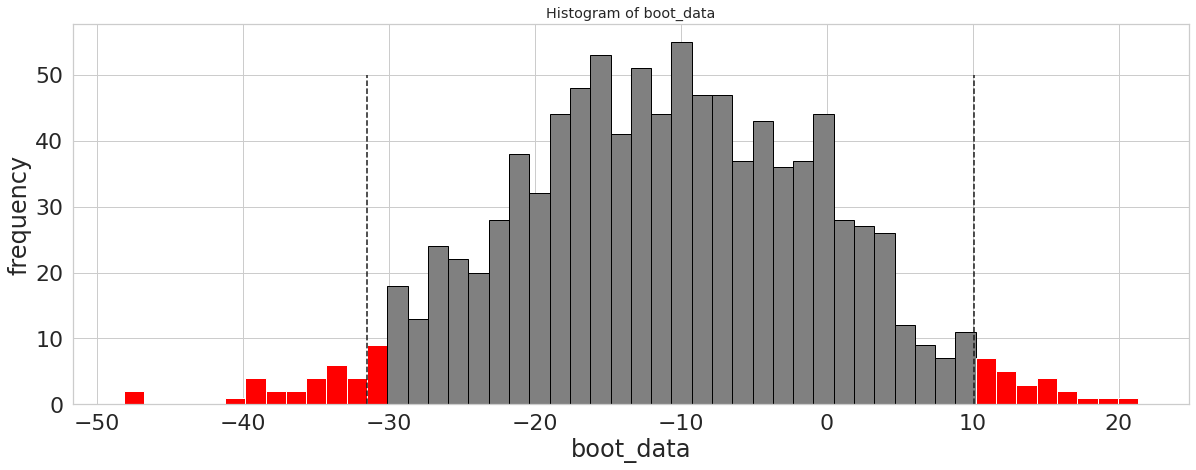

In [24]:
booted_data_arpu = get_bootstrap(active_users.query('grp == "A"').rev, 
                                 active_users.query('grp == "B"').rev)

In [25]:
booted_data_arpu["p_value"]  # альфа

0.3076665050898526

In [26]:
booted_data_arpu["quants"]  # ДИ

,0
0.025,-31.448944
0.975,10.074366


Значение p-value значительно больше 0.05, не можем отвергнуть нулевую гипотезу.

# Проверка для ARPPU

Н0: Средний доход на платящего пользователя (ARPPU) не отличается между группами

Н1: Средний доход на платящего пользователя (ARPPU) отличается между группами

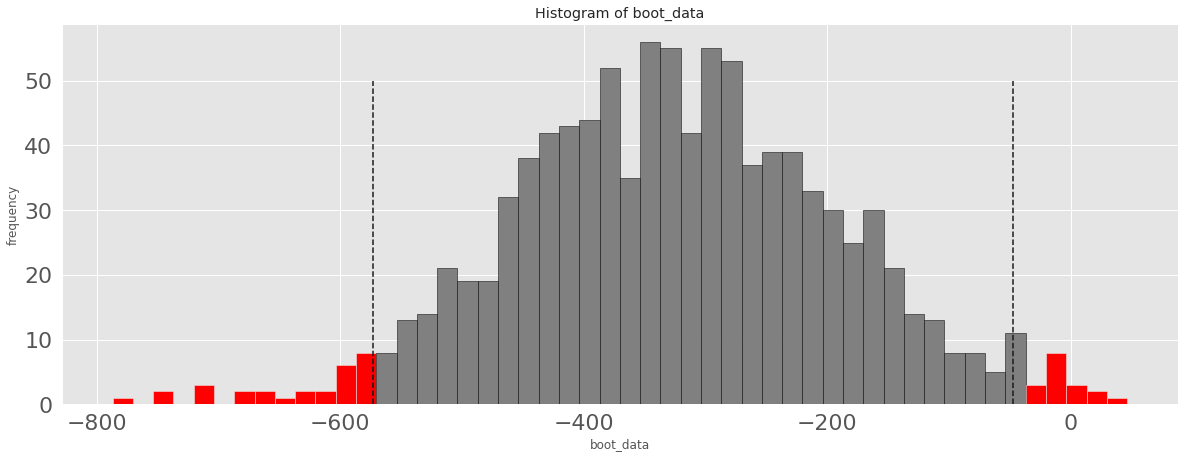

In [27]:
booted_data_arppu = get_bootstrap(active_users.query('grp == "A" & rev > 0').rev, 
                                  active_users.query('grp == "B" & rev > 0').rev)

In [28]:
booted_data_arppu["p_value"]  # альфа

0.014190756349446084

In [29]:
booted_data_arppu["quants"]  # ДИ

,0
0.025,-573.085590
0.975,-47.766353


Значение p-value меньше 0.05 и доверительный интервал не включает 0, можем отвергнуть нулевую гипотезу.

# Проверка для CR

Н0: Конверсия в платящего пользователя (CR) не отличается между группами

Н1: Конверсия в платящего пользователя (CR) отличается между группами

In [30]:
active_users['paying'] = active_users.rev > 0

In [31]:
pd.crosstab(active_users.paying, active_users.grp)

grp,A,B
paying,,
False,1460,6489
True,78,314


In [32]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(active_users.paying, active_users.grp))

In [33]:
stat, p

(0.48480826522557896, 0.48625240457231045)

Значение p-value значительно больше 0.05, не можем отвергнуть нулевую гипотезу.

# Стоит ли запускать новую механику на всех пользователей?

По проведенным тестам, значимо увеличился только ARPPU, остальные метрики не показали статистически значимых изменений.

Новую механику оплаты можно запустить на всех пользователей, но возможно перед этим необходимо будет проверить тест на честность и принять во внимание имеющиеся аномалии.

# Задание 2. SQL

# 2.1 Очень усердные ученики.

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

In [34]:
connection_default = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database': 'default',
    'user': 'student', 
    'password': 'dpo_python_2020'
}

In [35]:
good_students = '''
    SELECT st_id, toStartOfMonth(timest) AS month, COUNT(correct) AS tasks
    FROM default.peas
    WHERE correct = 1
    GROUP BY st_id, month
    HAVING COUNT(correct) >= 20
'''

In [36]:
ph.read_clickhouse(good_students, connection=connection_default)

,st_id,month,tasks
0,510283,2021-10-01,23
1,370846,2021-10-01,34
2,43985,2021-10-01,28
3,335446,2021-10-01,45
4,899745,2021-10-01,45
...,...,...,...
131,61717,2021-10-01,21
132,98637,2021-10-01,40
133,471168,2021-10-01,28
134,969749,2021-10-01,31


Получаем 136 усердных учеников.

# 2.2 Оптимизация воронки

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

    ARPU 
    ARPAU 
    CR в покупку 
    СR активного пользователя в покупку 
    CR пользователя из активности по математике (subject = 'math') в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [37]:
metrics = '''
WITH active_studs AS (
    SELECT 
        st_id, 
        COUNT(correct) AS tasks,
        sumIf(correct, subject = 'Math') AS math_tasks
    FROM default.peas
    WHERE correct = 1
    GROUP BY st_id
)

SELECT 
    test_grp, 
    ROUND(SUM(money) / COUNT(DISTINCT studs.st_id), 2) AS ARPU,
    ROUND(SUM(CASE WHEN tasks > 10 THEN money ELSE 0 END) / 
        COUNT(DISTINCT CASE WHEN tasks > 10 THEN studs.st_id END), 2) AS ARPAU,
    ROUND(100 * uniq(CASE WHEN final_project_check.money > 0 THEN studs.st_id END) / uniq(studs.st_id), 2) AS CR,
    ROUND(100 * uniq(CASE WHEN final_project_check.money > 0 AND active_studs.tasks > 10 THEN studs.st_id END) / 
        uniq(CASE WHEN active_studs.tasks > 10 THEN studs.st_id END), 2) AS CR_active,
    ROUND(100 * uniq(CASE WHEN final_project_check.money > 0 AND subject = 'Math' AND active_studs.math_tasks >= 2 
        THEN studs.st_id END) / uniq(CASE WHEN active_studs.math_tasks >= 2 THEN studs.st_id END), 2) AS CR_active_math
FROM default.studs
    LEFT JOIN default.final_project_check ON studs.st_id = final_project_check.st_id
    LEFT JOIN active_studs ON studs.st_id = active_studs.st_id
GROUP BY test_grp;
'''

In [38]:
ph.read_clickhouse(metrics, connection=connection_default)

,test_grp,ARPU,ARPAU,CR,CR_active,CR_active_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


# Задание 3. Python

# 3.1 Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [39]:
def recalculate_metrics(groups, groups_add, active_studs, checks):
    """Пересчитывает метрики.

    Функция принимает данные о группах, добавочных группах, активных студентах и оплатах,
    выполняет пересчет метрик и возвращает результат в виде датафрейма.

    Args:
        groups (DataFrame): Данные о группах.
        groups_add (DataFrame): Данные о добавочных группах.
        active_studs (DataFrame): Данные об активных студентах.
        checks (DataFrame): Данные об оплатах.

    Returns:
        DataFrame: Результаты пересчета метрик.
    """
    
    # Переименуем столбцы для удобства дальнейшей работы
    active_studs = active_studs.rename(columns={'student_id': 'id'})
    checks = checks.rename(columns={'student_id': 'id'})
    
    # Объединяем все данные по группам
    groups_all = pd.concat([groups, groups_add])
    
    # Создаем датафрейм для дальнейшей работы
    active_users = active_studs.merge(checks, how='left', on='id')
    active_users = active_users.merge(groups_all, how='left', on='id')
    
    # Пересчет метрик
    metrics = active_users.groupby('grp', as_index=False) \
                          .agg(all_users=('id', 'count'), 
                               paying_users=('rev', lambda x: x[x > 0].count()), 
                               revenue=('rev', 'sum'))

    metrics['CR'] = round(metrics['paying_users'] / metrics['all_users'] * 100, 2)
    metrics['ARPU'] = round(metrics['revenue'] / metrics['all_users'], 2)
    metrics['ARPPU'] = round(metrics['revenue'] / metrics['paying_users'], 2)
    
    return metrics

In [40]:
metrics = recalculate_metrics(groups, groups_add, active_studs, checks)
metrics

,grp,all_users,paying_users,revenue,CR,ARPU,ARPPU
0,A,1538,78.0,72820.0000,5.07,47.35,933.59
1,B,6803,314.0,394974.0035,4.62,58.06,1257.88


# 3.2 Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [41]:
def plot_metrics(metrics):
    """Отображает графики метрик.

    Функция принимает данные метрик в виде датафрейма и отображает три графика:
    Conversion Rate (CR), Average Revenue per User (ARPU) и Average Revenue per Paying User (ARPPU).

    Args:
        metrics (DataFrame): Данные метрик.

    Returns:
        Графики метрик.
    """
    
    # Создание графика для CR
    plt.figure(figsize=(8, 6))
    plt.bar(metrics['grp'], metrics['CR'])
    plt.xlabel('Group')
    plt.ylabel('CR (%)')
    plt.title('Conversion Rate (CR) by Group')
    plt.show()

    # Создание графика для ARPU
    plt.figure(figsize=(8, 6))
    plt.bar(metrics['grp'], metrics['ARPU'])
    plt.xlabel('Group')
    plt.ylabel('ARPU')
    plt.title('Average Revenue per User (ARPU) by Group')
    plt.show()

    # Создание графика для ARPPU
    plt.figure(figsize=(8, 6))
    plt.bar(metrics['grp'], metrics['ARPPU'])
    plt.xlabel('Group')
    plt.ylabel('ARPPU')
    plt.title('Average Revenue per Paying User (ARPPU) by Group')
    plt.show()

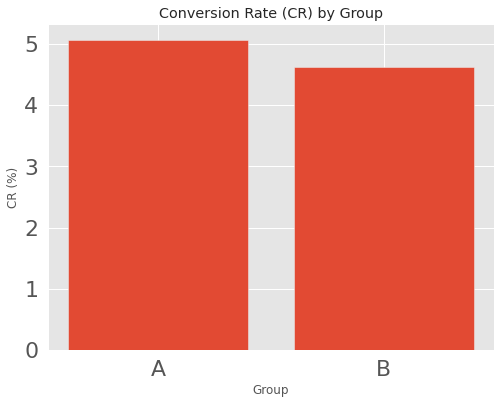

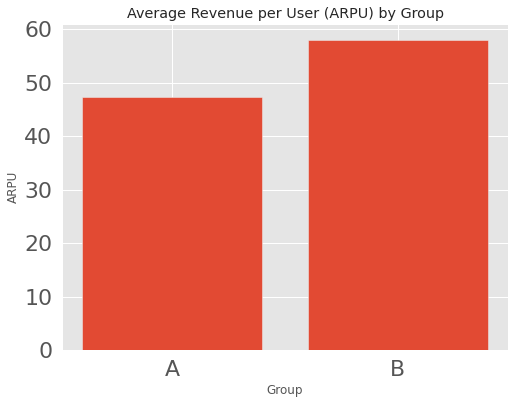

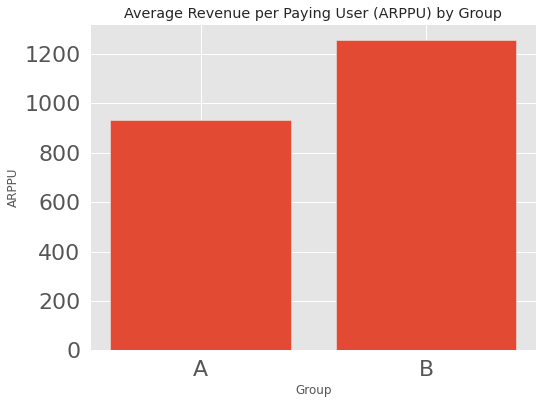

In [42]:
plot_metrics(metrics)